In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

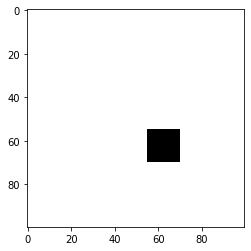

In [2]:
black_square = np.ones((100, 100))
black_square[55:70, 55:70] = 0
plt.imshow(black_square, cmap="gray")

100%|██████████| 100/100 [00:00<00:00, 10052.50it/s]


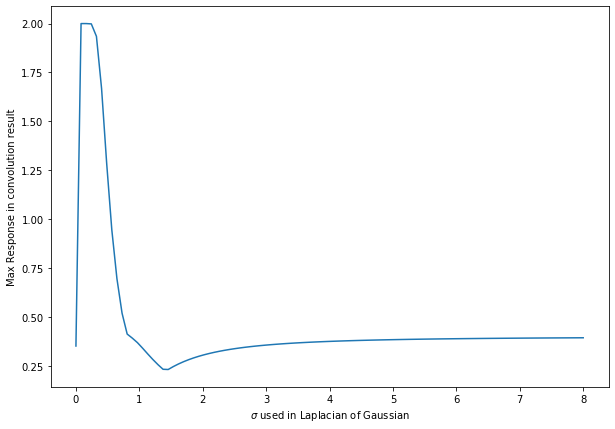

In [3]:
sigma = []
response = []

for i in tqdm(np.linspace(0, 8, 100)):
    blur = cv2.GaussianBlur(black_square, (5, 5), i)
    laplacian = cv2.Laplacian(blur, cv2.CV_64F)
    sigma.append(i)
    response.append(np.max(laplacian))
        
plt.figure(figsize=(10, 7))
plt.xlabel("$\sigma$ used in Laplacian of Gaussian")
plt.ylabel("Max Response in convolution result")
plt.plot(sigma, response)

## Q2) RANSAC

In [4]:
def apply_affine(vectors, M):
    assert M.shape == (2, 3)
    linear_map, displacement = M[:2, :2], M[0:, 2:]
    return (linear_map @ vectors.T).T + displacement.squeeze()

In [5]:
book_cover = cv2.imread("./Q2/Book_cover.jpg", cv2.IMREAD_GRAYSCALE)
book_pic = cv2.imread("./Q2/Book_pic.png", cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1_SIFT, desc1_SIFT = sift.detectAndCompute(book_cover, None)
kp2_SIFT, desc2_SIFT = sift.detectAndCompute(book_pic, None)

kp1, kp2, desc1, desc2 = kp1_SIFT, kp2_SIFT, desc1_SIFT, desc2_SIFT

In [6]:
# (brute force) matching of descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

# Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
good_matches = []
good_matches_without_list = []
for m, n in matches:
    if m.distance < 0.75 * n.distance: # only accept matchs that are considerably better than the 2nd best match
        good_matches.append([m])
        good_matches_without_list.append(m) # this is to simplify finding a homography later

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2).squeeze()
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2).squeeze()
print(src_pts.shape, dst_pts.shape)
N, _ = src_pts.shape

(672, 2) (672, 2)


In [7]:
# S = log(1 - P)/ log(1 - p ** k)
p, k, P = 0.5, 3, 0.995
S = int(np.ceil(np.log(1 - P) / np.log(1 - (p ** k))))

best_affine_M = None
best_qualify_num = -np.inf

for i in tqdm(range(S * 10)):
    rand_indices = np.random.randint(N, size=3)
    random_src = src_pts[rand_indices]
    random_dst = dst_pts[rand_indices]
    affine_M = cv2.getAffineTransform(random_src, random_dst)

    # transform all src into dst using this estimation
    estimated_dst = apply_affine(src_pts, affine_M)
    qualified_count = np.sum(np.sqrt(np.sum((estimated_dst - dst_pts) ** 2, axis=1)) <= 5)
    
    if qualified_count > best_qualify_num:
        best_qualify_num = qualified_count
        best_affine_M = affine_M

print(f"best_affine_M \n{best_affine_M}\n with number of matches {best_qualify_num}")

100%|██████████| 400/400 [00:00<00:00, 10497.11it/s]

best_affine_M 
[[ 6.81344413e-02 -2.30112476e-01  4.27499165e+02]
 [ 2.22774120e-01  1.96587312e-02  1.45754498e+02]]
 with number of matches 251


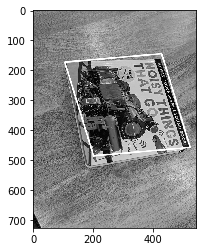

In [8]:
h,w = book_cover.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])

detected_book = apply_affine(pts, best_affine_M)

img3 = cv2.polylines(book_pic.copy(), [np.int32(detected_book)], True, 255, 3, cv2.LINE_AA)
plt.imshow(img3, 'gray')

In [9]:
detected_book

array([[427.49916499, 145.75449765],
       [105.57181128, 173.25706253],
       [201.02816359, 485.36360495],
       [522.9555173 , 457.86104006]])